In [ ]:
# 🧠 Experiment Orchestration Notebook

import os
import json
import subprocess
import matplotlib.pyplot as plt
import numpy as np

# 📂 Define the client IDs (e.g., 0, 1, 2 for three clients)
client_ids = [0, 1, 2]

# 🧪 Define the models to train for each client
models = ['lstm', 'gcn', 'gat']

# 🔧 Hyperparameters (shared for all experiments)
hidden_dim = 64
learning_rate = 0.001
epochs = 30
batch_size = 32

# 📦 Ensure the results directory exists
os.makedirs("results", exist_ok=True)


In [ ]:
# 🚀 Loop over each client and model combination to launch training
for client_id in client_ids:
    for model_type in models:
        print(f"\n🎯 Training {model_type.upper()} for Client {client_id}...")

        # 🛠️ Build the command to run train_client.py with appropriate arguments
        cmd = [
            "python", "src/train_client.py",
            "--client_id", str(client_id),
            "--model", model_type,
            "--hidden_dim", str(hidden_dim),
            "--lr", str(learning_rate),
            "--epochs", str(epochs),
            "--batch_size", str(batch_size)
        ]

        # 📡 Run the subprocess and capture its output (helpful for debugging)
        result = subprocess.run(cmd, capture_output=True, text=True)

        # 📝 Print training logs to notebook cell
        print(result.stdout)

        # 🧯 Print errors if any
        if result.stderr:
            print("⚠️ Error:", result.stderr)


In [ ]:
# 📈 Initialize empty lists for comparison
mae_data = {model: [] for model in models}
rmse_data = {model: [] for model in models}

# 📥 Load JSON results for each client
for client_id in client_ids:
    metrics_path = f"results/metrics_client{client_id}.json"

    if os.path.exists(metrics_path):
        with open(metrics_path, "r") as f:
            metrics = json.load(f)

        # 📊 Append metrics to corresponding model
        for model in models:
            mae_data[model].append(metrics[model]["MAE"])
            rmse_data[model].append(metrics[model]["RMSE"])
    else:
        print(f"❌ Missing: {metrics_path}")


In [ ]:
# 📊 Bar chart comparison for MAE and RMSE
x = np.arange(len(client_ids))  # [0, 1, 2]
width = 0.25  # width of each bar

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- MAE Plot ---
axs[0].bar(x - width, mae_data['lstm'], width, label='LSTM')
axs[0].bar(x,         mae_data['gcn'], width, label='GCN')
axs[0].bar(x + width, mae_data['gat'], width, label='GAT')
axs[0].set_title("📉 MAE Comparison")
axs[0].set_xticks(x)
axs[0].set_xticklabels([f"Client {i}" for i in client_ids])
axs[0].set_ylabel("Mean Absolute Error")
axs[0].legend()

# --- RMSE Plot ---
axs[1].bar(x - width, rmse_data['lstm'], width, label='LSTM')
axs[1].bar(x,         rmse_data['gcn'], width, label='GCN')
axs[1].bar(x + width, rmse_data['gat'], width, label='GAT')
axs[1].set_title("📈 RMSE Comparison")
axs[1].set_xticks(x)
axs[1].set_xticklabels([f"Client {i}" for i in client_ids])
axs[1].set_ylabel("Root Mean Squared Error")
axs[1].legend()

plt.tight_layout()
plt.savefig("results/plots/mae_rmse_comparison.png")
plt.show()


In [ ]:
import pandas as pd

# 📄 Create a summary DataFrame
summary_data = []

for i, client_id in enumerate(client_ids):
    summary_data.append({
        "Client ID": client_id,
        "LSTM_MAE": mae_data["lstm"][i],
        "GCN_MAE":  mae_data["gcn"][i],
        "GAT_MAE":  mae_data["gat"][i],
        "LSTM_RMSE": rmse_data["lstm"][i],
        "GCN_RMSE":  rmse_data["gcn"][i],
        "GAT_RMSE":  rmse_data["gat"][i],
    })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv("results/experiment_summary.csv", index=False)

print("✅ Summary saved to results/experiment_summary.csv")
summary_df


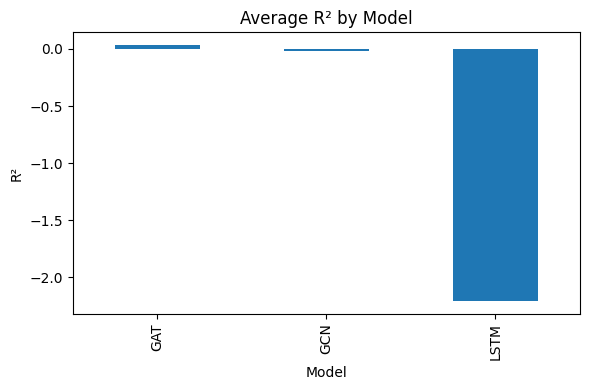

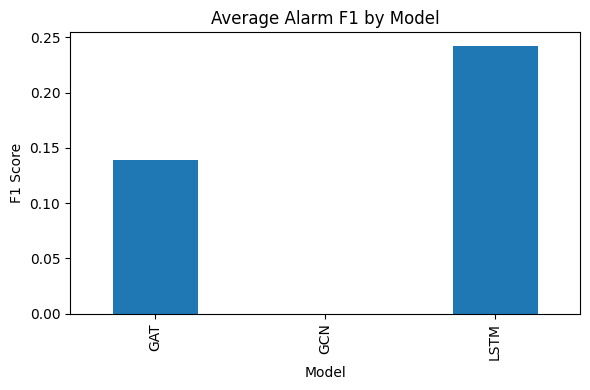

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('../results/extended_metrics.csv')

# R² comparison
df.groupby('Model')['R2'].mean().plot(
    kind='bar', title='Average R² by Model', figsize=(6,4))
plt.ylabel('R²'); plt.tight_layout(); plt.show()

# Alarm F1 comparison
df.groupby('Model')['F1'].mean().plot(
    kind='bar', title='Average Alarm F1 by Model', figsize=(6,4))
plt.ylabel('F1 Score'); plt.tight_layout(); plt.show()


c:\Users\Lenovo\Desktop\vs code projects\Explainable GNNs for IIOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\Desktop\vs code projects\Explainable GNNs for IIOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\Desktop\vs code projects\Explainable GNNs for IIOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

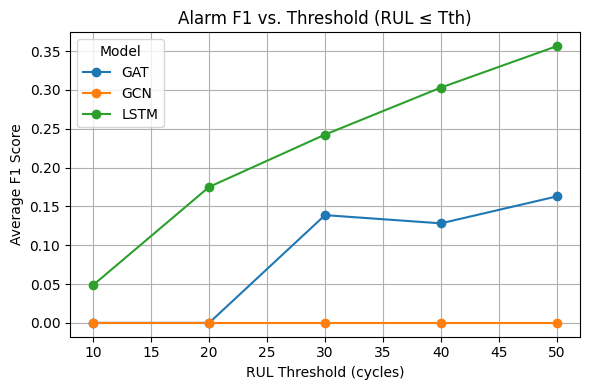

In [6]:
# — at the top of the notebook —
import sys, os
sys.path.insert(0, os.path.abspath('../src'))


import numpy as np
import pandas as pd
from eval_metrics import alarm_metrics

results = []
for model in ['LSTM','GCN','GAT']:
    for Tth in [10,20,30,40,50]:
        all_f1 = []
        for cid in [0,1,2]:
            trues = np.load(f'../results/trues_client{cid}_{model}.npy')
            preds = np.load(f'../results/preds_client{cid}_{model}.npy')
            am = alarm_metrics(trues, preds, Tth)
            all_f1.append(am['F1'])
        results.append({
            'Model'  : model,
            'Tth'    : Tth,
            'F1_mean': np.mean(all_f1)
        })
df_scan = pd.DataFrame(results)

# Pivot for plotting
pivot = df_scan.pivot(index='Tth', columns='Model', values='F1_mean')

# Plot
pivot.plot(marker='o', figsize=(6,4))
plt.title('Alarm F1 vs. Threshold (RUL ≤ Tth)')
plt.ylabel('Average F1 Score')
plt.xlabel('RUL Threshold (cycles)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import pandas as pd
import os
from eval_metrics import alarm_metrics, extended_metrics

# 1) Define the best threshold for each model (based on your F1‐vs‐Tth scan)
best_threshold = {
    'LSTM': 50,   # LSTM peaked at Tth=50
    'GCN': 30,    # if you decide GCN’s best is at 30 (even if F1=0)
    'GAT': 30,    # GAT peaked at Tth=30
}

records = []
for cid in [0,1,2]:
    for model in ['LSTM','GCN','GAT']:
        # paths to your .npy files
        trues_path = f"../results/trues_client{cid}_{model}.npy"
        preds_path = f"../results/preds_client{cid}_{model}.npy"
        if not os.path.exists(trues_path) or not os.path.exists(preds_path):
            continue

        # load arrays
        trues = np.load(trues_path)
        preds = np.load(preds_path)

        # 2) Compute regression metrics as usual
        em = extended_metrics(trues, preds)

        # 3) Compute alarm metrics at the *model‐specific* threshold
        Tth = best_threshold[model]
        am = alarm_metrics(trues, preds, Tth=Tth)

        # 4) Record everything
        rec = {
            'Client':    cid,
            'Model':     model,
            'Tth':       Tth,
            # regression metrics
            'MAE':       em['MAE'],
            'RMSE':      em['RMSE'],
            'R2':        em['R2'],
            'nMAE':      em['nMAE'],
            # alarm metrics at Tth
            'Precision': am['Precision'],
            'Recall':    am['Recall'],
            'F1':        am['F1'],
            'FAR':       am['FAR'],
            'HTR':       am['HTR'],
        }
        records.append(rec)

print(records)
# 5) Aggregate into a DataFrame
df_final = pd.DataFrame(records)

# 6) Save or display
df_final.to_csv('../results/final_metrics_per_model.csv', index=False)
print(df_final.groupby('Model')[['F1','Precision','Recall']].mean())


[{'Client': 0, 'Model': 'LSTM', 'Tth': 50, 'MAE': 174.73275387094867, 'RMSE': 195.59539025695958, 'R2': -3.935757298426264, 'nMAE': 0.3565974568794871, 'Precision': 0.055443548387096774, 'Recall': 1.0, 'F1': 0.10506208213944604, 'FAR': 1.0, 'HTR': 1.0}, {'Client': 0, 'Model': 'GCN', 'Tth': 30, 'MAE': 65.33172730476626, 'RMSE': 89.98511037534936, 'R2': -0.04466699356579551, 'nMAE': 0.13333005572401277, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'FAR': 0.0, 'HTR': 0.0}, {'Client': 0, 'Model': 'GAT', 'Tth': 30, 'MAE': 70.18748347989974, 'RMSE': 88.59291088765059, 'R2': -0.012592039582677517, 'nMAE': 0.14323976220387702, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'FAR': 0.0, 'HTR': 0.0}, {'Client': 1, 'Model': 'LSTM', 'Tth': 50, 'MAE': 60.47684930936255, 'RMSE': 83.0978186818744, 'R2': -1.05827597326804, 'nMAE': 0.13559831683713577, 'Precision': 0.4106060606060606, 'Recall': 1.0, 'F1': 0.5821697099892589, 'FAR': 1.0, 'HTR': 1.0}, {'Client': 1, 'Model': 'GCN', 'Tth': 30, 'MAE': 39.5380663

c:\Users\Lenovo\Desktop\vs code projects\Explainable GNNs for IIOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\Desktop\vs code projects\Explainable GNNs for IIOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\Desktop\vs code projects\Explainable GNNs for IIOT\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control 

This tells you, for each model, the early‐warning performance at its optimal alert horizon.

| Model | MAE (avg) | RMSE (avg) | R² (avg) | nMAE (avg) | F1 (avg @Tth) | Precision (avg) | Recall (avg) | Tth |
| :---: | :-------: | :--------: | :------: | :--------: | :-----------: | :-------------: | :----------: | :-: |
|  LSTM |   118.28  |   144.70   |   –2.52  |    0.246   |     0.356     |      0.2339     |      1.0     |  50 |
|  GCN  |   59.25   |    81.27   |  –0.018  |   0.1237   |     0.000     |      0.000      |      0.0     |  30 |
|  GAT  |   60.03   |    79.28   |   0.033  |    0.145   |     0.139     |      0.3208     |    0.0885    |  30 |
